In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Carregar o dataframe inicial
User = pd.read_excel('EVIO_history_01-02-2023_29-02-2024.xlsx')
User = User[['Start date','Stop date','Duration (min)', 'Total Energy (kWh)', 'Nº cartão EVIO']]

# Remover valores de carregamento de energia inferiores a 1 kWh
User = User[User['Total Energy (kWh)'] >= 1]

User = User[User['Nº cartão EVIO'] == 0]

# Remover valores de duração de carregamento inferiores a 5 minutos
User = User[User['Duration (min)'] >= 5]

User = User[['Start date','Stop date','Duration (min)', 'Total Energy (kWh)']]

print(User)

              Start date           Stop date  Duration (min)  \
31    02/25/2024 | 10:20  02/25/2024 | 10:37          16.500   
35    02/23/2024 | 08:37  02/23/2024 | 11:31         174.000   
52    02/20/2024 | 14:12  02/20/2024 | 20:23         370.850   
61    02/19/2024 | 08:31  02/19/2024 | 11:39         188.083   
91    02/11/2024 | 10:48  02/11/2024 | 11:14          25.983   
...                  ...                 ...             ...   
1536  04/03/2023 | 08:39  04/03/2023 | 13:38         298.967   
1542  03/31/2023 | 08:48  03/31/2023 | 13:36         288.500   
1545  03/31/2023 | 08:41  03/31/2023 | 10:26         105.350   
1548  03/31/2023 | 08:37  03/31/2023 | 08:45           8.283   
1559  03/29/2023 | 08:35  03/29/2023 | 10:26         111.117   

      Total Energy (kWh)  
31                 28.52  
35                 31.10  
52                 27.23  
61                 35.26  
91                 22.06  
...                  ...  
1536               43.80  
1542           

In [3]:
# Convertendo as colunas de data para o formato de data especificado
User['Start date'] = pd.to_datetime(User['Start date'], format='%m/%d/%Y | %H:%M')
User['Stop date'] = pd.to_datetime(User['Stop date'], format='%m/%d/%Y | %H:%M')


# Criando uma nova coluna 'Date' que contém apenas a data (sem a hora)
User['Date'] = User['Start date'].dt.date

# Convertendo os valores de energia para o formato numérico adequado
#User['Total Energy (kWh)'] = User['Total Energy (kWh)'].str.replace(',', '.').astype(float)

# Agrupando os dados pela coluna 'Date' e somando os valores de 'Total Energy (kWh)'
User = User.groupby('Date')['Total Energy (kWh)'].sum().reset_index()

print(User)

# Criando um intervalo de datas que cubra todo o período de interesse
date_range = pd.date_range(start=User['Date'].min(), end=User['Date'].max(), freq='D')

# Criando um DataFrame com o intervalo de datas
date_df = pd.DataFrame({'Date': date_range})

# Renomeando a coluna 'Date' para 'Date_new'
date_df.rename(columns={'Date': 'Date_new'}, inplace=True)

# Convertendo a coluna 'Date' em 'daily_energy_sum' para datetime
User['Date'] = pd.to_datetime(User['Date'])

# Mesclando os DataFrames usando merge
merged_df = pd.merge(date_df, User, left_on='Date_new', right_on='Date', how='left')

# Preenchendo os valores ausentes na coluna 'Total Energy (kWh)' com zero
merged_df['Total Energy (kWh)'].fillna(0, inplace=True)
merged_df = merged_df.drop(columns=['Date'])
merged_df.rename(columns={'Date_new': 'Date'}, inplace=True)

print(merged_df)

# Adicionar a coluna 'Carregar'
merged_df['Carregar'] = merged_df['Total Energy (kWh)'] > 0

# Visualizar as primeiras linhas do DataFrame
print(merged_df.head())

           Date  Total Energy (kWh)
0    2023-03-29               12.60
1    2023-03-31               61.66
2    2023-04-03               43.80
3    2023-04-05               51.27
4    2023-04-06               29.33
..          ...                 ...
107  2024-02-11               22.06
108  2024-02-19               35.26
109  2024-02-20               27.23
110  2024-02-23               31.10
111  2024-02-25               28.52

[112 rows x 2 columns]
          Date  Total Energy (kWh)
0   2023-03-29               12.60
1   2023-03-30                0.00
2   2023-03-31               61.66
3   2023-04-01                0.00
4   2023-04-02                0.00
..         ...                 ...
329 2024-02-21                0.00
330 2024-02-22                0.00
331 2024-02-23               31.10
332 2024-02-24                0.00
333 2024-02-25               28.52

[334 rows x 2 columns]
        Date  Total Energy (kWh)  Carregar
0 2023-03-29               12.60      True
1 2023-03-30  

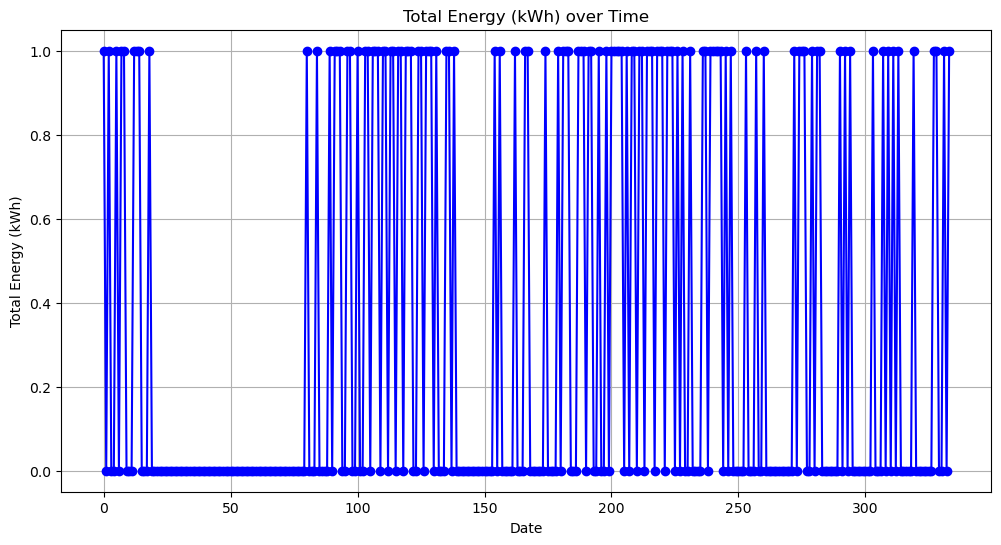

In [4]:
import matplotlib.pyplot as plt

# Plotar a série temporal
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Carregar'], marker='o', linestyle='-', color='b')
plt.title('Total Energy (kWh) over Time')
plt.xlabel('Date')
plt.ylabel('Total Energy (kWh)')
plt.grid(True)
plt.show()

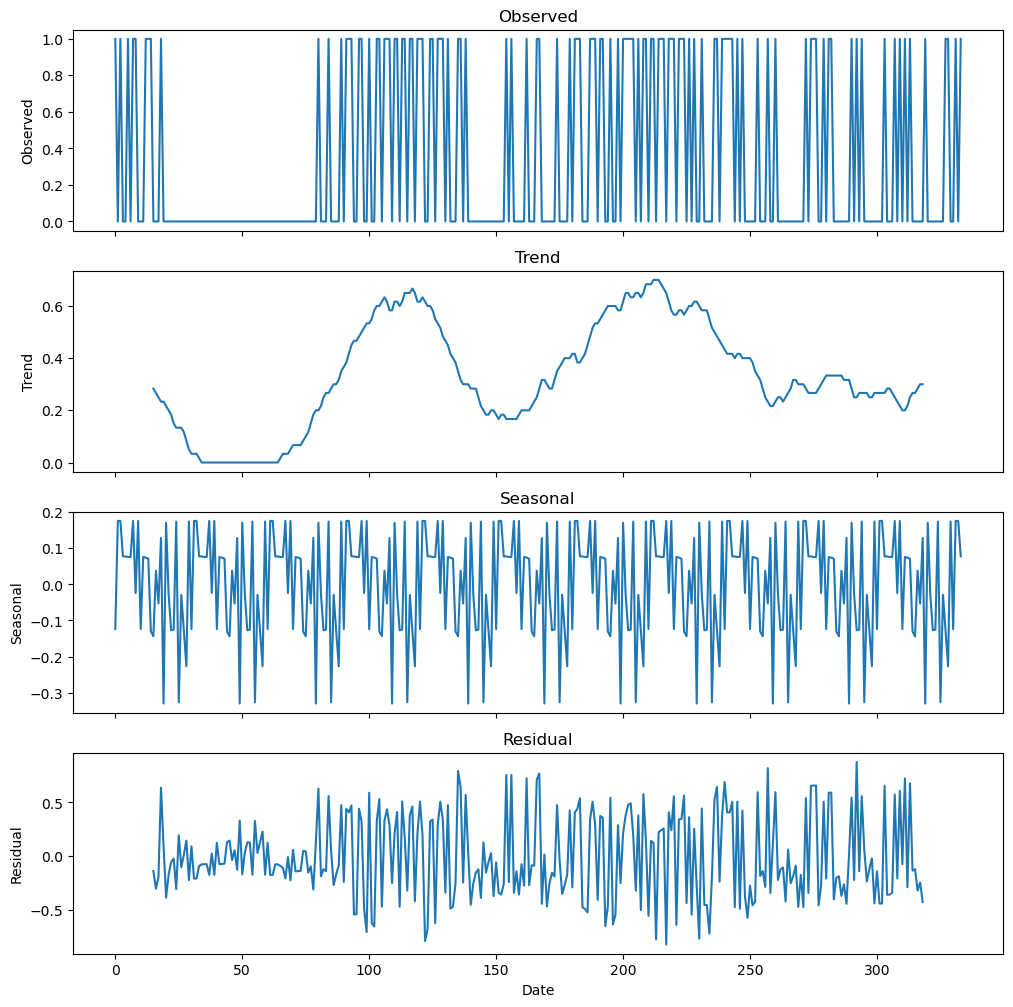

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompor a série temporal
decomposition = seasonal_decompose(merged_df['Carregar'], model='additive', period=30)

# Plotar a decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Residual')

plt.xlabel('Date')
plt.show()

<Figure size 1200x600 with 0 Axes>

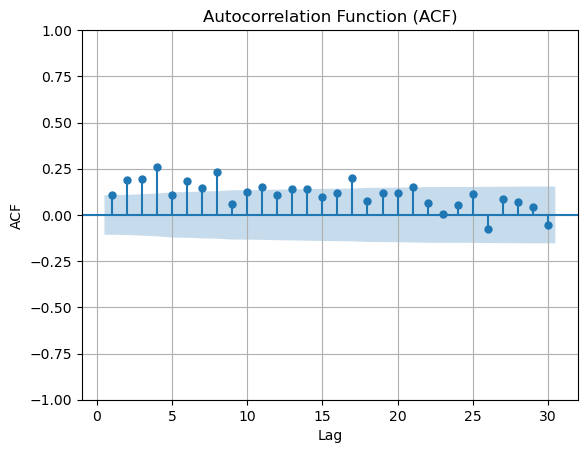

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

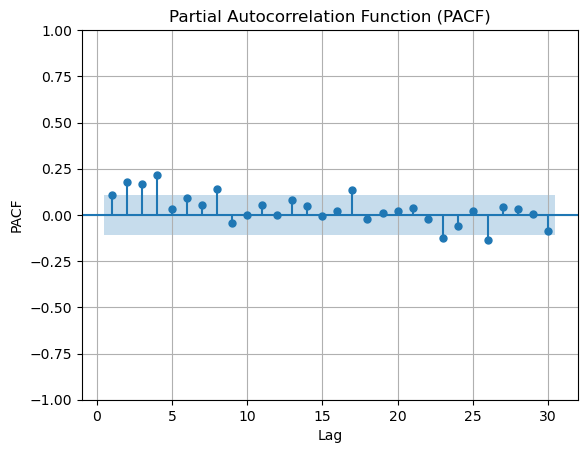

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotar ACF
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Carregar'], lags=30, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plotar PACF
plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Carregar'], lags=30, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

C:\Users\miguel.preto\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\miguel.preto\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.49


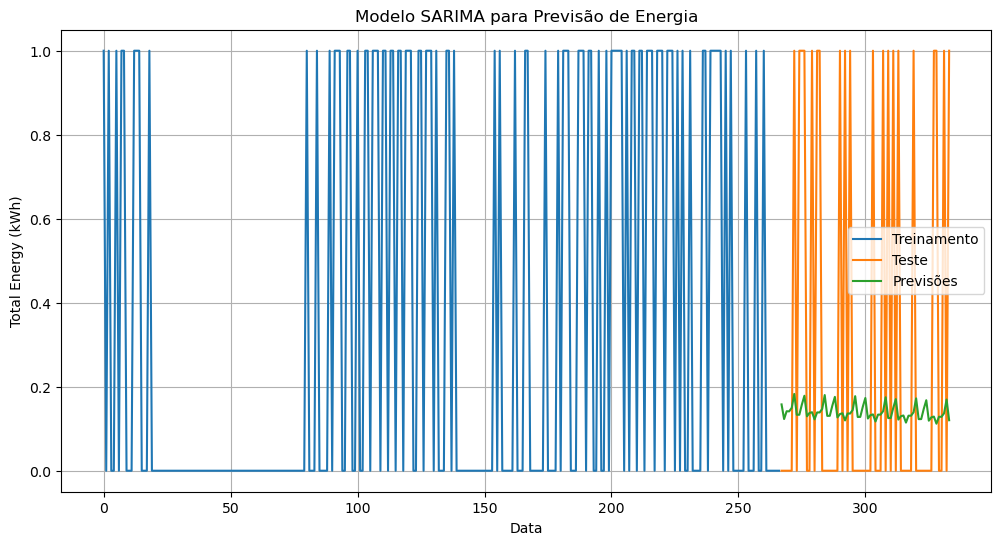

267    0.157890
268    0.123053
269    0.141620
270    0.141334
271    0.149662
         ...   
329    0.128414
330    0.128360
331    0.136602
332    0.169502
333    0.120225
Name: predicted_mean, Length: 67, dtype: float64


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools

# Usar apenas a coluna 'Total Energy (kWh)' para treinamento
train = merged_df['Carregar']

# Dividir em treinamento e teste
train_size = int(len(train) * 0.8)
train_data, test_data = train.iloc[:train_size], train.iloc[train_size:]

# Ajustar o modelo SARIMA
# Exemplo inicial, os parâmetros precisam ser ajustados com base na análise anterior
# Aqui estamos considerando um modelo SARIMA(1, 1, 1)x(1, 0, 1, 12) como exemplo
# Isso significa:
# - p = 1 (ordem do AR)
# - d = 1 (ordem da diferenciação)
# - q = 1 (ordem do MA)
# - P = 1 (ordem do AR sazonal)
# - D = 0 (ordem da diferenciação sazonal)
# - Q = 1 (ordem do MA sazonal)
# - m = 12 (período sazonalidade, aqui assumimos sazonalidade anual com período 12 meses)

model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()

# Fazer previsões
forecast = model_fit.forecast(steps=len(test_data))

# Calcular RMSE
rmse = mean_squared_error(test_data, forecast, squared=False)
print(f'RMSE: {rmse:.2f}')

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Treinamento')
plt.plot(test_data.index, test_data, label='Teste')
plt.plot(test_data.index, forecast, label='Previsões')
plt.title('Modelo SARIMA para Previsão de Energia')
plt.xlabel('Data')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()

print(forecast)